# Environment Setup

To ensure the environment is correctly set up, follow these steps to download the dataset and install any necessary non-standard libraries.

## Libraries Set Up

In [1]:
 ! pip install -q kaggle

In [9]:
! pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


## Dataset Set Up


In [6]:
kaggle_json = {"username": "yijuli52", "key": "fe29da176c7e73aa458e22be06340fe4"}

import json
with open('kaggle.json', 'w') as file:
    json.dump(kaggle_json, file)

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d anirudhcv/labeled-optical-coherence-tomography-oct

Dataset URL: https://www.kaggle.com/datasets/anirudhcv/labeled-optical-coherence-tomography-oct
License(s): unknown
100% 6.69G/6.70G [01:29<00:00, 112MB/s]
100% 6.70G/6.70G [01:29<00:00, 80.0MB/s]


In [3]:
!unzip labeled-optical-coherence-tomography-oct.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5822041-15.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5822041-16.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5822041-18.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5822041-2.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5822041-8.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-582215-6.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-582215-7.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-582215-8.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5823731-1.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5823731-5.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5824080-5.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5824080-6.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5830194-10.jpeg  

# Data Exploration

In [16]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import Counter
import seaborn as sns

In [5]:
dataset_path = '/content/Dataset - train+val+test'

## About the Dataset: Classes

Number of images: 109309
Number of classes: 4
Class distribution: Counter({'NORMAL': 51390, 'CNV': 37455, 'DME': 11598, 'DRUSEN': 8866})


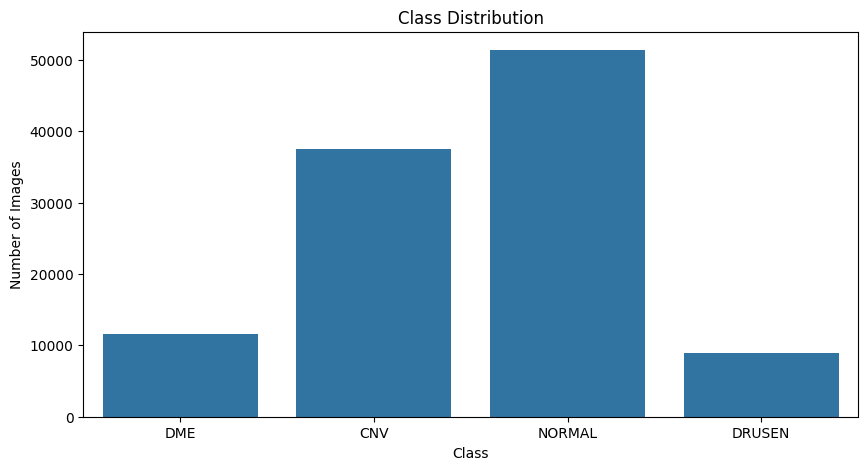

In [6]:
def get_image_paths_and_labels(dataset_path):
    image_paths = []
    labels = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.jpeg'):
                image_paths.append(os.path.join(root, file))
                labels.append(root.split(os.path.sep)[-1])
    return image_paths, labels

image_paths, labels = get_image_paths_and_labels(dataset_path)

num_images = len(image_paths)
num_classes = len(set(labels))

print(f"Number of images: {num_images}")
print(f"Number of classes: {num_classes}")

class_distribution = Counter(labels)
print(f"Class distribution: {class_distribution}")

plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

## About the Dataset: Examples

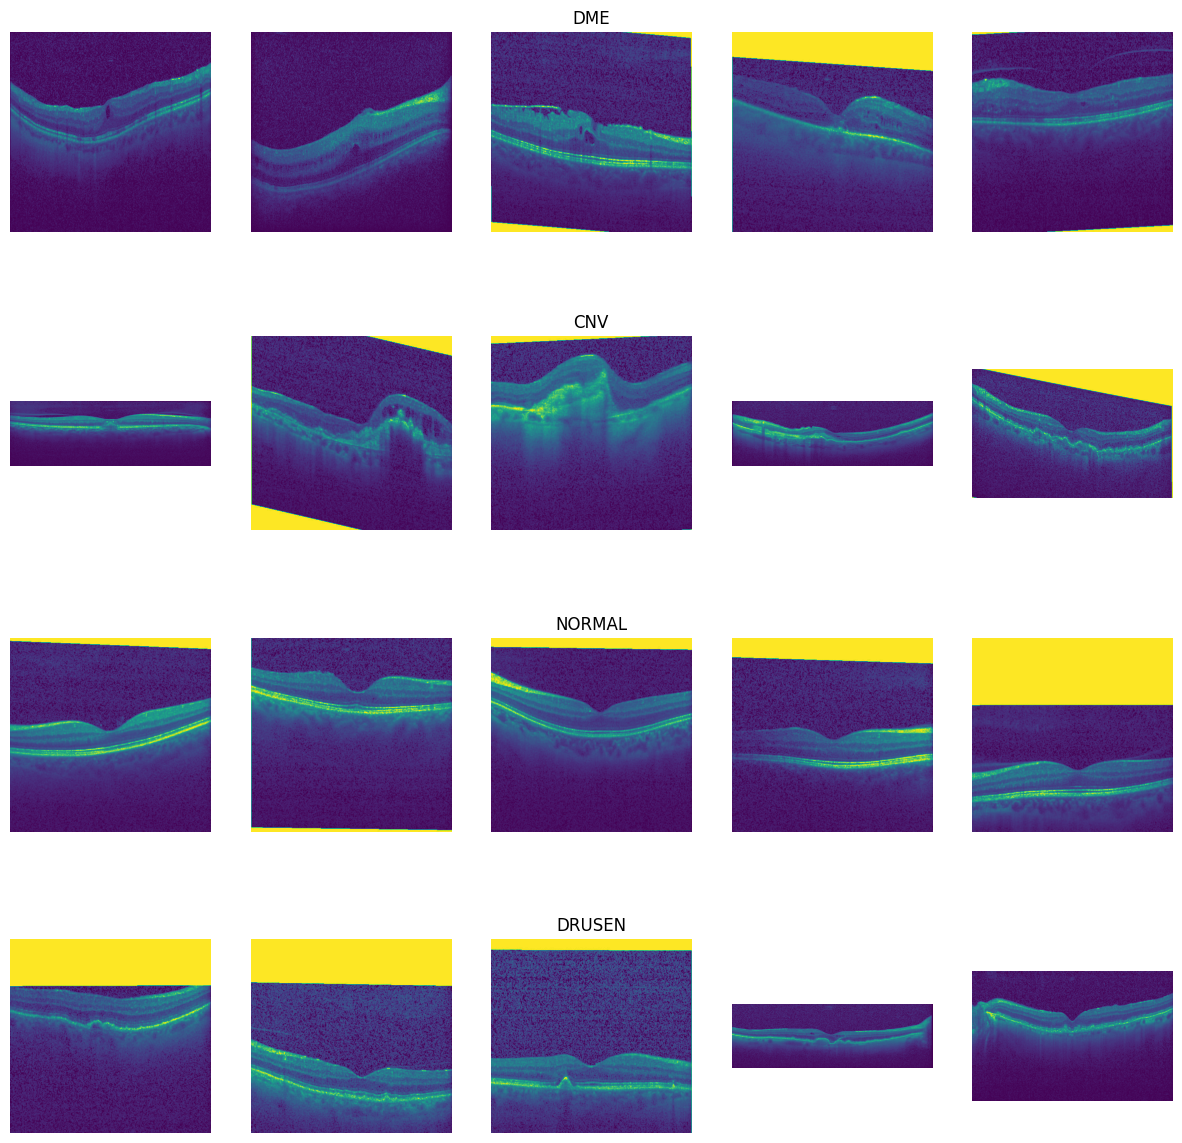

In [7]:
def plot_example_images(image_paths, labels, class_distribution, num_examples=5):
    plt.figure(figsize=(15, 15))
    for i, cls in enumerate(class_distribution.keys()):
        cls_images = [image_paths[j] for j in range(len(image_paths)) if labels[j] == cls]
        for j in range(num_examples):
            img = Image.open(cls_images[j])
            plt.subplot(len(class_distribution), num_examples, i * num_examples + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == num_examples // 2:
                plt.title(cls)
    plt.show()

plot_example_images(image_paths, labels, class_distribution)

In [8]:
image_sizes = [Image.open(img_path).size for img_path in image_paths]

Image size distribution:
Size: (512, 512), Count: 8659
Size: (512, 496), Count: 58037
Size: (768, 496), Count: 29749
Size: (1536, 496), Count: 11512
Size: (1024, 496), Count: 1329
Size: (384, 496), Count: 21
Size: (900, 455), Count: 1
Size: (642, 277), Count: 1


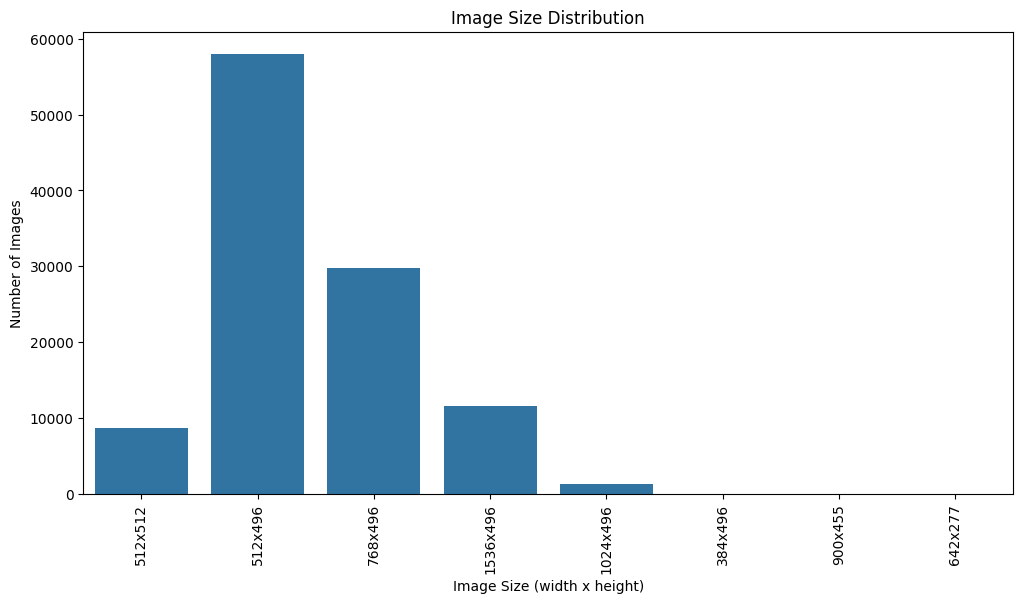

In [9]:
size_distribution = Counter(image_sizes)

print("Image size distribution:")
for size, count in size_distribution.items():
    print(f"Size: {size}, Count: {count}")

plt.figure(figsize=(12, 6))
sizes, counts = zip(*size_distribution.items())
sizes = [f"{size[0]}x{size[1]}" for size in sizes]  # Format sizes as strings
sns.barplot(x=sizes, y=counts)
plt.title('Image Size Distribution')
plt.xlabel('Image Size (width x height)')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.show()

# Preprocessing

## Crop

In [10]:
from tqdm import tqdm
import tensorflow as tf

def crop_center(img, cropx, cropy):
    y, x = img.shape[0], img.shape[1]
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty+cropy, startx:startx+cropx]

target_size = (496, 496)

def preprocess_images(image_paths, target_size):
    for img_path in tqdm(image_paths, desc="Processing images"):
        img = Image.open(img_path)
        img = np.array(img)
        img = crop_center(img, *target_size)
        img = Image.fromarray(img)
        img.save(img_path)

preprocess_images(image_paths, target_size)


Processing images: 100%|██████████| 109309/109309 [08:03<00:00, 226.14it/s]


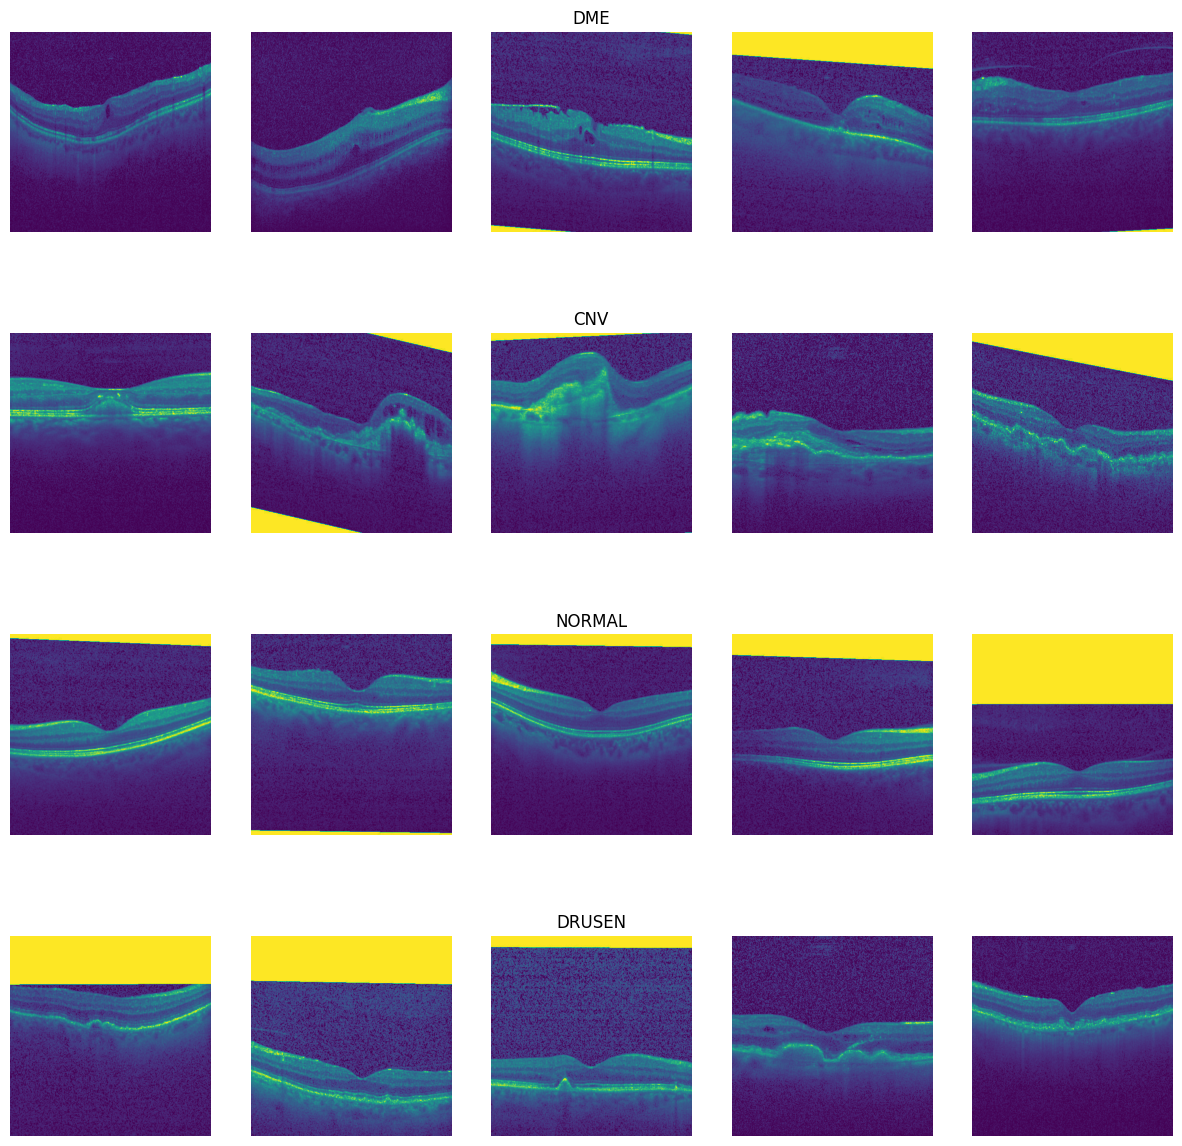

In [12]:
plot_example_images(image_paths, labels, class_distribution)

## Convert to Tensor

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

def load_data(directory):
    data_gen = ImageDataGenerator(rescale=1./255)
    data_flow = data_gen.flow_from_directory(
        directory,
        target_size=(496, 496),
        color_mode='grayscale',  # Specify color mode here
        batch_size=32,
        class_mode='sparse'
    )

    images, labels = [], []
    for img_batch, label_batch in data_flow:
        for img, label in zip(img_batch, label_batch):
            images.append(img)
            labels.append(label)
        # Break loop after one iteration to avoid infinite loop
        break

    return tf.convert_to_tensor(images), tf.convert_to_tensor(labels)

In [2]:
train_images, train_labels = load_data('/content/Dataset - train+val+test/train')

Found 76515 images belonging to 4 classes.


In [19]:
train_images.shape

TensorShape([32, 496, 496, 1])

In [5]:
val_images, val_labels = load_data('/content/Dataset - train+val+test/val')
test_images, test_labels = load_data('/content/Dataset - train+val+test/test')

Found 21861 images belonging to 4 classes.
Found 10933 images belonging to 4 classes.


# Train

## Approach #1: Simple CNNs

In [3]:
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(496, 496, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(4, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [6]:
model = create_model()

# Train the model on GPU
with tf.device('/GPU:0'):
    history = model.fit(
        train_images, train_labels,
        epochs=100,
        validation_data=(val_images, val_labels)
)

Epoch 1/100
1/1 [==============================] - 15s 15s/step - loss: 1.3830 - accuracy: 0.2500 - val_loss: 4.2505 - val_accuracy: 0.4062
Epoch 2/100
1/1 [==============================] - 0s 389ms/step - loss: 2.7456 - accuracy: 0.5000 - val_loss: 3.4507 - val_accuracy: 0.4688
Epoch 3/100
1/1 [==============================] - 0s 411ms/step - loss: 3.1121 - accuracy: 0.4062 - val_loss: 1.1852 - val_accuracy: 0.4688
Epoch 4/100
1/1 [==============================] - 0s 419ms/step - loss: 1.0782 - accuracy: 0.4062 - val_loss: 1.3211 - val_accuracy: 0.4062
Epoch 5/100
1/1 [==============================] - 0s 408ms/step - loss: 1.0854 - accuracy: 0.5000 - val_loss: 1.2427 - val_accuracy: 0.4062
Epoch 6/100
1/1 [==============================] - 0s 326ms/step - loss: 0.9643 - accuracy: 0.5000 - val_loss: 1.0814 - val_accuracy: 0.5312
Epoch 7/100
1/1 [==============================] - 0s 332ms/step - loss: 0.9074 - accuracy: 0.5000 - val_loss: 1.0898 - val_accuracy: 0.6875
Epoch 8/100
1/

In [8]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

1/1 [==============================] - 0s 101ms/step - loss: 42.3965 - accuracy: 0.3438
Test accuracy: 0.34375


1/1 [==============================] - 0s 119ms/step - loss: 3.3528e-08 - accuracy: 1.0000
Training accuracy: 1.0, Training loss: 3.352760558072987e-08
1/1 [==============================] - 0s 124ms/step - loss: 42.3965 - accuracy: 0.3438
Test accuracy: 0.34375, Test loss: 42.396453857421875


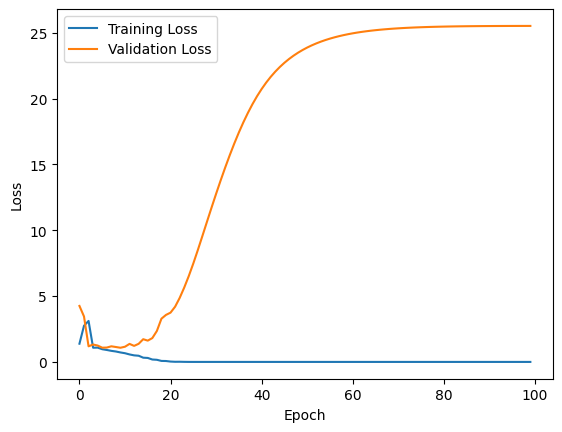

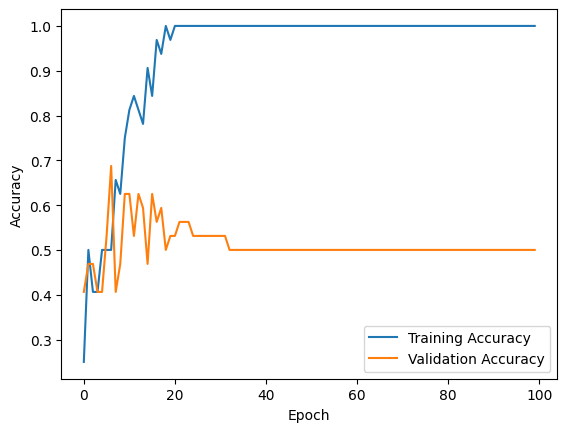

In [17]:
train_loss, train_acc = model.evaluate(train_images, train_labels)
print(f'Training accuracy: {train_acc}, Training loss: {train_loss}')

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Approach #2: Using Tuner on #1

In [12]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import keras_tuner as kt

In [10]:
def build_model(hp):
    model = models.Sequential()

    model.add(layers.Conv2D(
        hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),
        hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(496, 496, 1)
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(layers.Conv2D(
            hp.Int(f'conv_{i+2}_filter', min_value=32, max_value=128, step=32),
            hp.Choice(f'conv_{i+2}_kernel', values=[3, 5]),
            activation='relu'
        ))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(
        hp.Int('dense_units', min_value=128, max_value=512, step=128),
        activation=hp.Choice('dense_activation', values=['relu', 'tanh'])
    ))
    model.add(layers.Dense(4, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [13]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='keras_tuner_dir',
    project_name='oct_model_tuning'
)

In [14]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    train_images, train_labels,
    epochs=50,
    validation_data=(val_images, val_labels),
    callbacks=[stop_early]
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of filters in the first convolutional layer is {best_hps.get('conv_1_filter')} and the optimal kernel size is {best_hps.get('conv_1_kernel')}.
The optimal number of dense units is {best_hps.get('dense_units')} with {best_hps.get('dense_activation')} activation function.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 3 Complete [00h 00m 15s]

Best val_accuracy So Far: 0.46875
Total elapsed time: 00h 01m 15s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
128               |32                |conv_1_filter
5                 |3                 |conv_1_kernel
1                 |2                 |num_conv_layers
96                |128               |conv_2_filter
3                 |3                 |conv_2_kernel
128               |384               |dense_units
tanh              |tanh              |dense_activation
0.00016316        |0.00065708        |learning_rate
96                |32                |conv_3_filter
5                 |3                 |conv_3_kernel
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/eng

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

Detected at node Adam/StatefulPartitionedCall_4 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-14-717efb760689>", line 5, in <cell line: 5>

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 234, in search

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 544, in minimize

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1223, in apply_gradients

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1253, in _internal_apply_gradients

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1345, in _distributed_apply_gradients_fn

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1340, in apply_grad_to_update_var

Out of memory while trying to allocate 1463156868 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    2.72GiB
              constant allocation:         8B
        maybe_live_out allocation:    2.04GiB
     preallocated temp allocation:    1.36GiB
  preallocated temp fragmentation:       124B (0.00%)
                 total allocation:    4.09GiB
Peak buffers:
	Buffer 1:
		Size: 697.69MiB
		XLA Label: fusion
		Shape: f32[1428864,128]
		==========================

	Buffer 2:
		Size: 697.69MiB
		XLA Label: fusion
		Shape: f32[1428864,128]
		==========================

	Buffer 3:
		Size: 697.69MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[1428864,128]
		==========================

	Buffer 4:
		Size: 697.69MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[1428864,128]
		==========================

	Buffer 5:
		Size: 697.69MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[1428864,128]
		==========================

	Buffer 6:
		Size: 697.69MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[1428864,128]
		==========================

	Buffer 7:
		Size: 24B
		Operator: op_type="AssignSubVariableOp" op_name="AssignSubVariableOp" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: fusion
		Shape: (f32[1428864,128], f32[1428864,128], f32[1428864,128])
		==========================

	Buffer 8:
		Size: 8B
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: s64[]
		==========================

	Buffer 9:
		Size: 4B
		Operator: op_type="Pow" op_name="Pow_1" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.4"
		XLA Label: fusion
		Shape: f32[]
		==========================

	Buffer 10:
		Size: 4B
		Operator: op_type="Pow" op_name="Pow" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.4"
		XLA Label: fusion
		Shape: f32[]
		==========================

	Buffer 11:
		Size: 4B
		Operator: op_type="Pow" op_name="Pow_1" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: constant
		Shape: f32[]
		==========================

	Buffer 12:
		Size: 4B
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[]
		==========================

	Buffer 13:
		Size: 4B
		Operator: op_type="Pow" op_name="Pow" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: constant
		Shape: f32[]
		==========================


	 [[{{node Adam/StatefulPartitionedCall_4}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_11363]
